In [8]:
import pandas as pd
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
#import kerastuner as kt
#from sklearn.model_selection import train_test_split
from scipy.constants import eV, c, h, hbar, m_e
from scipy.constants import physical_constants
from scipy import linalg

amu = physical_constants['atomic mass constant'][0]
bohr = physical_constants['Bohr radius'][0]


In [23]:
#all_data=pd.read_csv("G:\OneDrive - bwedu\Master\Forschungspraktikum\Inga\pc-forschi\generated_Data/all_param_4_values_complete.csv")
all_data=pd.read_csv("/home/tcstud25/MCTDH/First Test with pyr4/generated_Data/all_param_4_values_complete.csv")

all_label_list=["k6a1","k6a2","k11","k12","k9a1","k9a2","delta","lambda"]

#first 50 are just for testing
df_labels=all_data[all_label_list]#.head(10000)#/27.211396

df_labels.head()


,k6a1,k6a2,k11,k12,k9a1,k9a2,delta,lambda
0,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.6000,0.1000
1,-0.1,-0.1,-0.1,-0.1,-0.1,-0.0333,0.6000,0.2333
2,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.6000,0.2333
3,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.5333,0.2333
4,-0.1,-0.1,-0.1,-0.1,-0.1,-0.1000,0.5333,0.1000


In [24]:
#Omegas
#w10a = 0.09357, ev

ev_to_au=1/27.211396
w6a = 0.0740* ev_to_au
w1 = 0.1273* ev_to_au
w9a = 0.1568 * ev_to_au


#vibrational potentials
def potential_s0(q,omega):
    pot=omega/2 * q**2
    #print("Vs0",pot)
    return pot

def potential_s1(q,omega, df_k_s1,sigma=0):
    pot=np.asarray([omega/2 * q**2 +k_s1*ev_to_au*q +sigma for k_s1 in df_k_s1])
   # print("Vs1",pot)
    return pot

def potential_s2(q,omega,df_k_s2,sigma=0,delta=0):
    pot=np.asarray([omega/2 * q**2 +k_s2*ev_to_au*q +sigma+2*delta for k_s2 in df_k_s2])
   # print("Vs2",pot)
    return pot

def get_mu(m1,m2):
    mu = m1*m2/(m1+m2)
    return mu

def get_k(mu,omega):
    k = mu*(2*np.pi*omega)**2
    return k



(65464, 100)


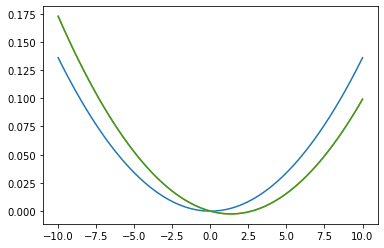

In [25]:
x_grid,h_grid=np.linspace(-10,10,100,retstep=True)
R0 = 2.9

#normal parameters for pyrazin
k6a1 = -0.0964* ev_to_au
k6a2 = 0.1194 * ev_to_au
k11 = 0.0470 * ev_to_au
k12 = 0.2012 * ev_to_au
k9a1 = 0.1594 * ev_to_au
k9a2 = 0.0484 * ev_to_au
sigma=3.81* ev_to_au
delta = 0.46165* ev_to_au
_lambda = 0.1825 * ev_to_au


vs0_w6a= potential_s0(x_grid,w6a)
vs1_w6a= potential_s1(x_grid,w6a,df_labels["k6a1"])
vs2_w6a= potential_s2(x_grid,w6a,df_labels["k6a2"])
print(vs1_w6a.shape)


plt.plot(x_grid,vs0_w6a)
plt.plot(x_grid,vs1_w6a[0])
plt.plot(x_grid,vs2_w6a[0])


In [26]:
#setup some test things
nsteps=100

#returns a df with only the possible combinations
def get_all_combinations_one_mode(df,label_list):
    df_mode=df[label_list].drop_duplicates()
    #print(df_mode.head(10))
    return df_mode


#print(df_all_k6a_combinations.head())


#this returns a multi dimensional array with all energys and wavefunctions for all
#potentials given in the potential list of one mode

#return shape: 
# layer 1 s0,s1,s2
# layer 2 eigenstates HO (0:100)
# layer 3 wave_function
def get_s0_1_2_energy_wavef(x_grid,h_grid,omega,v_s0,v_s1,v_s2):
    nsteps=len(x_grid)
    #print(h_grid)
    Hamiltonian_s0=np.zeros((nsteps,nsteps))
    Hamiltonian_s1=np.zeros((nsteps,nsteps))
    Hamiltonian_s2=np.zeros((nsteps,nsteps))
    [i,j] = np.indices(Hamiltonian_s0.shape)
    Laplacian=(-2.0*np.diag(np.ones(nsteps))+np.diag(np.ones(nsteps-1),1)+
               np.diag(np.ones(nsteps-1),-1))/(float)(h_grid**2)
    Hamiltonian_s0[i==j]=v_s0
    Hamiltonian_s1[i==j]=v_s1
    Hamiltonian_s2[i==j]=v_s2
    
    Hamiltonian_s0+=(-1*w6a)*Laplacian
    Hamiltonian_s1+=(-1*w6a)*Laplacian
    Hamiltonian_s2+=(-1*w6a)*Laplacian
    
    energies_s0, wavef_s0 = linalg.eigh(Hamiltonian_s0)
    energies_s1, wavef_s1 = linalg.eigh(Hamiltonian_s1)
    energies_s2, wavef_s2 = linalg.eigh(Hamiltonian_s2)
    #print((wavef_s1.shape))

    #print(wavef_s1.shape)
    #i only need the first 5 eigenstates
    wave_f_complete=np.asarray([wavef_s0.T[:5],wavef_s1.T[:5],wavef_s2.T[:5]])
    energies_complete=np.asarray([energies_s0[:5],energies_s1[:5],energies_s2[:5]])
    
    return energies_complete,wave_f_complete


def get_all_energy_wavef_per_mode(x_grid,h_grid,omega,df,label_list):
    df_all_combinations=get_all_combinations_one_mode(df_labels,label_list)
    
    
    
    
    
    dict_all_combi_with_energies_wavef={label_list[0]:[],label_list[1]:[],"energy_s0":[],
                                       "energy_s1":[],"energy_s2":[],"wave_f_s0":[],
                                        "wave_f_s1":[],"wave_f_s2":[]}
    
    
    for combi in df_all_combinations.values:
        #print(combi[0],combi[1])
        dict_all_combi_with_energies_wavef[label_list[0]].append(combi[0])
        dict_all_combi_with_energies_wavef[label_list[1]].append(combi[1])
        #dict_all_combi_with_energies_wavef[label_list[0]].append(0)
        #dict_all_combi_with_energies_wavef[label_list[1]].append(100)
        vs0_w6a= potential_s0(x_grid,omega)
        #vs1_w6a= potential_s1(x_grid,omega,[0])
        #vs2_w6a= potential_s2(x_grid,omega,[0.001])
        vs1_w6a= potential_s1(x_grid,omega,[combi[0]])
        vs2_w6a= potential_s2(x_grid,omega,[combi[1]])
        energy,wave_f=get_s0_1_2_energy_wavef(x_grid,h_grid,w6a,vs0_w6a,vs1_w6a[0],vs2_w6a[0])
        #append energies
        dict_all_combi_with_energies_wavef["energy_s0"].append(energy[0])
        dict_all_combi_with_energies_wavef["energy_s1"].append(energy[1])
        dict_all_combi_with_energies_wavef["energy_s2"].append(energy[2])
        #append wavef
        dict_all_combi_with_energies_wavef["wave_f_s0"].append(wave_f[0])
        dict_all_combi_with_energies_wavef["wave_f_s1"].append(wave_f[1])
        dict_all_combi_with_energies_wavef["wave_f_s2"].append(wave_f[2])
        
    df_one_mode=pd.DataFrame(dict_all_combi_with_energies_wavef)
    #print(df_one_mode.head())
    
    
    return df_one_mode


def overlap_integral_s0_s2_s1(df_mode,label_list,mode_name):
    #print(df_mode)

    df_overlap=df_mode[label_list]
    #print(df["wave_f_s2"].to_numpy()[0][:])
    #for i in range(len(df_mode["wave_f_s2"].to_numpy()[0])):
    #    print("sum of int",(np.sum(df_mode["wave_f_s0"].to_numpy()[0][0]*df_mode["wave_f_s2"].to_numpy()[0][i]))**2  )
       # df_overlap["overlap_s0_s2"]=([np.sum(df_mode["wave_f_s0"].to_numpy()[0][0]*
            #                                df_mode["wave_f_s2"].to_numpy()[0][i])**2]  )
        
    #df_overlap["overlap_s0_s2"]=[[np.sum(df_mode["wave_f_s0"].to_numpy()[0][0]*wave_f_s2)**2      for wave_f_s2 in df_mode["wave_f_s2"].to_numpy()[0]] ]
       
    #outer loop
    list_of_overlaps_s0_s2=[]
    for i,case in enumerate(df_mode["wave_f_s2"].to_numpy()):
        list_of_overlaps_s0_s2.append([])
        for j in case:
            #print(np.sum(df_mode["wave_f_s0"].to_numpy()[0][0]*i)**2)
            list_of_overlaps_s0_s2[-1].append(
                round(np.sum(df_mode["wave_f_s0"].to_numpy()[i][0]*j)**2,4) )
                    
    df_overlap["overlap_s0_s2_"+mode_name]=list_of_overlaps_s0_s2    
    index_max_overlap_s2=[ overlaps.index(max(overlaps))    for overlaps in df_overlap["overlap_s0_s2_"+mode_name]     ]
    df_overlap["max_overlap_s0_s2_"+mode_name]=[  max(overlaps) for overlaps in df_overlap["overlap_s0_s2_"+mode_name]     ]
    df_overlap["index_max_overlap_s0_s2_"+mode_name]=[ overlaps.index(max(overlaps)) for overlaps in df_overlap["overlap_s0_s2_"+mode_name]     ]

    
    #print(index_max_overlap_s2)
        
    #df_overlap["overlap_s0_s2"]=np.sum(df["wave_f_s0"].values*df["wave_f_s2"].values)

    list_of_overlaps_s2_s1=[]
    for i,case in enumerate(df_mode["wave_f_s1"].to_numpy()):
        list_of_overlaps_s2_s1.append([])
        for j in case:
            #print(np.sum(df_mode["wave_f_s0"].to_numpy()[0][0]*i)**2)
            list_of_overlaps_s2_s1[-1].append(round(np.sum(
                df_mode["wave_f_s2"].to_numpy()[i][index_max_overlap_s2[i]]*j)**2,4) )
                    
    df_overlap["overlap_s2_s1_"+mode_name]=list_of_overlaps_s2_s1    
    index_max_overlap_s1=[ overlaps.index(max(overlaps))    for overlaps in df_overlap["overlap_s2_s1_"+mode_name]     ]
    df_overlap["max_overlap_s2_s1_"+mode_name]=[  max(overlaps) for overlaps in df_overlap["overlap_s2_s1_"+mode_name]     ]
    df_overlap["index_max_overlap_s2_s1_"+mode_name]=[ overlaps.index(max(overlaps)) for overlaps in df_overlap["overlap_s2_s1_"+mode_name]     ]

    
    
    #print(df_overlap.head(50))
    
    return df_overlap
    

In [27]:
ev_to_au=1/27.211396
w6a = 0.0740* ev_to_au
w1 = 0.1273* ev_to_au
w9a = 0.1568 * ev_to_au

df_get_all_k6a=get_all_energy_wavef_per_mode(x_grid,h_grid,w6a,df_labels,["k6a1","k6a2"])
df_overlap_k6a=overlap_integral_s0_s2_s1(df_get_all_k6a,["k6a1","k6a2"],"k6a")
#reset label values
#df_overlap_k6a[["k6a1","k6a2"]] = df_overlab_k6a[["k6a1","k6a2"]].apply(lambda x: x*27.211396)
df_overlap_k6a.to_csv("df_overlap_k6a.csv")     
    
df_get_all_k1=get_all_energy_wavef_per_mode(x_grid,h_grid,w1,df_labels,["k11","k12"])
df_overlap_k1=overlap_integral_s0_s2_s1(df_get_all_k1,["k11","k12"],"k1")
df_overlap_k1.to_csv("df_overlap_k1.csv")     

    
df_get_all_k9a=get_all_energy_wavef_per_mode(x_grid,h_grid,w9a,df_labels,["k9a1","k9a2"])
df_overlap_k9a=overlap_integral_s0_s2_s1(df_get_all_k9a,["k9a1","k9a2"],"k9a")
df_overlap_k9a.to_csv("df_overlap_k9a.csv")     


<ipython-input-26-ba0716f3d14f>:112: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_overlap["overlap_s0_s2_"+mode_name]=list_of_overlaps_s0_s2
<ipython-input-26-ba0716f3d14f>:114: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_overlap["max_overlap_s0_s2_"+mode_name]=[  max(overlaps) for overlaps in df_overlap["overlap_s0_s2_"+mode_name]     ]
<ipython-input-26-ba0716f3d14f>:115: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_ind

In [28]:
#df_labels.loc[((df_labels['k6a1']==df_overlab_k6a['k6a1']) and 
#               (df_labels['k6a2']==df_overlab_k6a['k6a2'])), 
#              'max_overlap_s0_s2'] = 1

#merge the overlap results into the main df
df_labels=df_labels.merge(df_overlap_k6a,on=["k6a1","k6a2"])
df_labels=df_labels.merge(df_overlap_k1,on=["k11","k12"])
df_labels=df_labels.merge(df_overlap_k9a,on=["k9a1","k9a2"])


df_labels[["k6a1","k6a2"]]=df_labels[["k6a1","k6a2"]]

df_labels.head(100)

,k6a1,k6a2,k11,k12,k9a1,k9a2,delta,lambda,overlap_s0_s2_k6a,max_overlap_s0_s2_k6a,...,index_max_overlap_s0_s2_k1,overlap_s2_s1_k1,max_overlap_s2_s1_k1,index_max_overlap_s2_s1_k1,overlap_s0_s2_k9a,max_overlap_s0_s2_k9a,index_max_overlap_s0_s2_k9a,overlap_s2_s1_k9a,max_overlap_s2_s1_k9a,index_max_overlap_s2_s1_k9a
0,-0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.6000,0.1000,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
1,-0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.6000,0.2333,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
2,-0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.5333,0.2333,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
3,-0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.5333,0.1000,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
4,-0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.4667,0.3667,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.0333,0.1,-0.1,-0.1,-0.1,-0.1,0.6000,0.5000,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
96,0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.5333,0.1000,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
97,0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.5333,0.2333,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0
98,0.1000,-0.1,-0.1,-0.1,-0.1,-0.1,0.6000,0.1000,"[0.5232, 0.3386, 0.1098, 0.0239, 0.004]",0.5232,...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0


In [29]:
all_data=all_data.merge(df_labels,on=["k6a1","k6a2","k11","k12","k9a1","k9a2","delta","lambda"])


In [30]:
all_data.head(100)

,k6a1,k6a2,k11,k12,k9a1,k9a2,delta,lambda,main_maximum,all_maxima,...,index_max_overlap_s0_s2_k1,overlap_s2_s1_k1,max_overlap_s2_s1_k1,index_max_overlap_s2_s1_k1,overlap_s0_s2_k9a,max_overlap_s0_s2_k9a,index_max_overlap_s0_s2_k9a,overlap_s2_s1_k9a,max_overlap_s2_s1_k9a,index_max_overlap_s2_s1_k9a
0,-0.1,-0.1,-0.1,-0.1,-0.1000,-0.1000,0.6000,0.1000,0.540,[0.466 0.54 0.612 0.67 0.742],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0000,0
1,-0.1,-0.1,-0.1,-0.1,-0.1000,-0.0333,0.6000,0.2333,0.510,[0.51 0.584 0.65 0.712 0.778],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.9769, 0.0228, 0.0003, 0.0, 0.0]",0.9769,0,"[0.9106, 0.0852, 0.004, 0.0001, 0.0]",0.9106,0
2,-0.1,-0.1,-0.1,-0.1,-0.1000,-0.1000,0.6000,0.2333,0.556,[0.482 0.556 0.628 0.686 0.756],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0000,0
3,-0.1,-0.1,-0.1,-0.1,-0.1000,-0.1000,0.5333,0.2333,0.418,[0.418 0.492 0.564 0.622 0.692],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0000,0
4,-0.1,-0.1,-0.1,-0.1,-0.1000,-0.1000,0.5333,0.1000,0.474,[0.4 0.474 0.546 0.604 0.676],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0000,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,-0.1,-0.1,-0.1,-0.1,-0.0333,0.0333,0.4000,0.3667,0.350,[0.35 0.424 0.49 0.552 0.618],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.9769, 0.0228, 0.0003, 0.0, 0.0]",0.9769,0,"[0.9109, 0.085, 0.004, 0.0001, 0.0]",0.9109,0
96,-0.1,-0.1,-0.1,-0.1,-0.0333,0.1000,0.4667,0.3667,0.384,[0.384 0.458 0.53 0.588 0.66 0.734],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.8102, 0.1704, 0.018, 0.0013, 0.0001]",0.8102,0,"[0.6881, 0.257, 0.0481, 0.0061, 0.0006]",0.6881,0
97,-0.1,-0.1,-0.1,-0.1,-0.0333,-0.0333,0.6000,0.5000,0.556,[0.556 0.63 0.698 0.758 0.826],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.9769, 0.0228, 0.0003, 0.0, 0.0]",0.9769,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0000,0
98,-0.1,-0.1,-0.1,-0.1,-0.0333,0.0333,0.4000,0.5000,0.462,[0.39 0.462 0.53 0.59 0.656],...,0,"[1.0, 0.0, 0.0, 0.0, 0.0]",1.0,0,"[0.9769, 0.0228, 0.0003, 0.0, 0.0]",0.9769,0,"[0.9109, 0.085, 0.004, 0.0001, 0.0]",0.9109,0


In [31]:
df_test=pd.DataFrame()
list_test=[0,1,2]
list_test2= [[1,2],[3,4],[5,6]]
df_test["first test"] = list_test
df_test["second test"] = list_test2


df_test.head()


,first test,second test
0,0,"[1, 2]"
1,1,"[3, 4]"
2,2,"[5, 6]"
